In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_color_codes('pastel')

%matplotlib inline

In [2]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.datasets import make_classification, make_regression
from sklearn.datasets import load_boston, load_iris, make_moons

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

In [3]:
class IdentityScaler(TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return X
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    
    def inverse_transform(self, X):
        return X

In [4]:
class FlowMachine(BaseEstimator):
    
    def __init__(self, top=None, theta=0.5,
                 normalize=False, random_state=None):
        self.norm = np.linalg.norm
        self.top = top
        self.normalize = normalize
        self.random_state = random_state
        self.x_scaler = StandardScaler() if normalize else IdentityScaler()
        self.y_scaler = StandardScaler() if normalize else IdentityScaler()
        self.theta = theta
        
    def choice(self, X):
        count = int(self.theta * len(X))
        shuffled = shuffle(
            X, random_state=self.random_state
        )
        return shuffled[:count]
    
    def unit(self, vector):
        normed = self.norm(vector)
        if not np.allclose(normed, 0):
            return np.asarray(vector) / normed
        return np.inf
    
    def construct(self, points):
        dimension = len(points[0])
        codimension = len(points[0]) - 1
        hyperplanes = []
        distances = []
        for index in range(len(points) - 1):
            distances.append((
                self.norm(points[index + 1] - points[index]),
                points[index] # store original point
            ))
        distances = sorted(distances, key=lambda value: value[0])
        for index in range(0, len(distances), dimension):
            if index + dimension >= len(distances):
                continue
            total = np.asarray([
                data[1] for data in distances[index:index+dimension]
            ])
            try:
                normal = np.linalg.solve(
                    total, np.ones(shape=(dimension, 1))
                ).ravel()
            except:
                # skip singular matrices
                continue
            normal = self.unit(normal)
            hyperplanes.append((
                normal,
                distances[index][1] # store one point of hyperplane
            ))
        self.hyperplanes = hyperplanes
    
    def distance(self, hyperplane, point):
        return np.abs(np.dot((point - hyperplane[1]), hyperplane[0]))
    
    def fit(self, X, y):
        X = np.copy(X)
        X = self.x_scaler.fit_transform(X)
        
        y = np.copy(y).reshape(-1, 1)
        y = self.y_scaler.fit_transform(y).flatten()
        
        self.construct(self.choice(X))
        
        vectors = self.compute(X)
        self.top.fit(vectors, y)
        
        return self
    
    def compute(self, X):
        vectors = []
        for x in X:
            vector = []
            for hyperplane in self.hyperplanes:
                vector.append(self.distance(hyperplane, x))
            vectors.append(vector)
        return np.asarray(vectors)
    
    def predict(self, X):
        result = []
        X = self.x_scaler.transform(np.copy(X))
        
        return self.y_scaler.inverse_transform(
            self.top.predict(self.compute(X)).reshape(-1, 1)
        ).flatten()
    
    def score(self, X, y):
        return self.top.score(
            self.compute(self.x_scaler.transform(X)),
            y.reshape(-1, 1)
        )

In [5]:
folds = 5
state = 1

In [6]:
iris_data = load_iris()
boston_data = load_boston()

train_cX, test_cX, train_cy, test_cy = train_test_split(
    iris_data.data,
    iris_data.target,
    test_size=0.3,
    random_state=state
)

train_rX, test_rX, train_ry, test_ry = train_test_split(
    boston_data.data,
    boston_data.target,
    test_size=0.3,
    random_state=state
)

In [7]:
%%time

c_pred = FlowMachine(LogisticRegression(
    solver='lbfgs', multi_class='ovr'
)).fit(
    train_cX, train_cy
).predict(test_cX)

r_pred = FlowMachine(LinearRegression(), random_state=1).fit(
    train_rX, train_ry
).predict(test_rX)

CPU times: user 96 ms, sys: 4 ms, total: 100 ms
Wall time: 220 ms


In [8]:
%%time

r_base = Ridge(random_state=state).fit(
    train_rX, train_ry
).predict(test_rX)

c_base = LogisticRegression(
    solver='lbfgs', multi_class='ovr', random_state=state
).fit(
    train_cX, train_cy
).predict(test_cX)

CPU times: user 52 ms, sys: 4 ms, total: 56 ms
Wall time: 103 ms


In [9]:
print("Regression MAE: %.3f, R2: %.3f" % (
    mean_absolute_error(test_ry, r_pred),
    r2_score(test_ry, r_pred)
))

print("Base MAE: %.3f, R2: %.3f" % (
    mean_absolute_error(test_ry, r_base),
    r2_score(test_ry, r_base)
))

Regression MAE: 5.901, R2: 0.255
Base MAE: 3.289, R2: 0.789


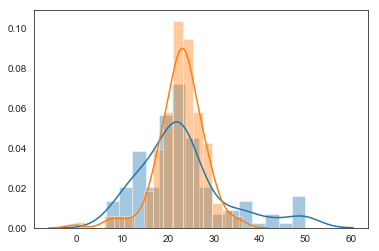

In [10]:
sns.distplot(test_ry);
sns.distplot(r_pred);

In [11]:
print(confusion_matrix(test_cy, c_pred))
print(confusion_matrix(test_cy, c_base))

[[14  0  0]
 [ 0 15  3]
 [ 0  0 13]]
[[14  0  0]
 [ 0 13  5]
 [ 0  1 12]]


In [12]:
print(classification_report(test_cy, c_pred))
print(classification_report(test_cy, c_base))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.83      0.91        18
           2       0.81      1.00      0.90        13

   micro avg       0.93      0.93      0.93        45
   macro avg       0.94      0.94      0.94        45
weighted avg       0.95      0.93      0.93        45

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.93      0.72      0.81        18
           2       0.71      0.92      0.80        13

   micro avg       0.87      0.87      0.87        45
   macro avg       0.88      0.88      0.87        45
weighted avg       0.89      0.87      0.87        45



## Second part
Synthetic datasets with cross-validation.

In [13]:
def check_regressors(X, y):
    for regressor in [
        FlowMachine(LinearRegression(), random_state=state),
        Ridge(random_state=state),
        LinearSVR(random_state=state),
        RandomForestRegressor(random_state=state),
        KNeighborsRegressor()
    ]:
        scores = cross_val_score(
            regressor,
            X=X, y=y,
            cv=KFold(folds)
        )
        
        print(type(regressor).__name__, "%.4f" % scores.mean())

In [14]:
rX, ry = make_regression(
    n_samples=2000,
    n_features=20,
    n_informative=4,
    noise=50.,
    random_state=state
)

check_regressors(rX, ry)

FlowMachine 0.0736
Ridge 0.7927
LinearSVR 0.7884
RandomForestRegressor 0.6842
KNeighborsRegressor 0.4493


In [15]:
rX, ry = make_regression(
    n_samples=500,
    n_features=10,
    n_informative=8,
    noise=150.,
    random_state=state
)

check_regressors(rX, ry)

FlowMachine 0.1363
Ridge 0.4442
LinearSVR 0.3862
RandomForestRegressor 0.3472
KNeighborsRegressor 0.2961


In [16]:
rX, ry = make_regression(
    n_samples=500,
    n_features=4,
    n_informative=4,
    noise=1.,
    random_state=state
)

ry = np.sin(np.log(1 + ry**2))

check_regressors(rX, ry)

FlowMachine 0.3632
Ridge -0.0351
LinearSVR -0.0900
RandomForestRegressor 0.3078
KNeighborsRegressor 0.4079


In [17]:
def check_classifiers(X, y):
    for classifier in [
        FlowMachine(
            LogisticRegression(solver='lbfgs', multi_class='ovr'),
            random_state=state
        ),
        LogisticRegression(random_state=state),
        LinearSVC(random_state=state),
        RandomForestClassifier(random_state=state),
        KNeighborsClassifier()
    ]:
        scores = cross_val_score(
            classifier,
            X=X, y=y,
            scoring=make_scorer(f1_score, average='micro'),
            cv=StratifiedKFold(folds)
        )
        
        print(type(classifier).__name__, "%.4f" % scores.mean())

In [18]:
cX, cy = make_classification(
    n_samples=100,
    n_features=10,
    n_informative=5,
    n_redundant=0,
    n_classes=5,
    weights=None,
    hypercube=False,
    random_state=state
)

check_classifiers(cX, cy)

FlowMachine 0.2868
LogisticRegression 0.3187
LinearSVC 0.3187
RandomForestClassifier 0.2176
KNeighborsClassifier 0.3405


In [19]:
cX, cy = make_classification(
    n_samples=2000,
    n_features=50,
    n_informative=50,
    n_redundant=0,
    n_classes=2,
    weights=[.1],
    hypercube=False,
    random_state=state
)

check_classifiers(cX, cy)

FlowMachine 0.9085
LogisticRegression 0.9000
LinearSVC 0.8890
RandomForestClassifier 0.8935
KNeighborsClassifier 0.9155


In [20]:
cX, cy = make_moons(
    n_samples=500,
    noise=.5,
    random_state=state
)

check_classifiers(cX, cy)

FlowMachine 0.8380
LogisticRegression 0.8220
LinearSVC 0.8220
RandomForestClassifier 0.7820
KNeighborsClassifier 0.8000
